# import

In [1]:
import pandas as pd
import numpy as np
import os
import json
from pathlib import Path
from typing import Tuple
from collections import defaultdict
import ruamel.yaml
from typing import Union
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
from scipy.signal import sawtooth
import matplotlib.pyplot as plt

# hlo read temp path set

In [2]:
def temporary_path_fn(match_str):
# use pathlib to get all files in the folder called test_data

    # PWD using pathlib
    path = Path.cwd().parent


    # move to the parent directory

    # add test_data to the path using pathlib
    path = os.path.join(path, "test_data")

    # get all files in the folder
    files = os.listdir(path)

    # return the file that contains "CV"
    spec_file= [file for file in files if match_str in file]

    # join path to the file
    spec_file = os.path.join(path, spec_file[0])

    return spec_file
    # read the file
    #meta, data = read_hlo(spec_file)#, keep_keys=["tick_time"])




def yml_load(input: Union[str, Path]):
    """
    Load a YAML file or string.

    This function loads a YAML file or string using the ruamel.yaml library.
    It supports loading from a file path, a Path object, or a YAML string.

    Args:
        input (Union[str, Path]): The input YAML data. This can be a file path (str),
                                  a Path object, or a YAML string.

    Returns:
        obj: The loaded YAML data as a Python object.

    Raises:
        FileNotFoundError: If the input is a file path that does not exist.
        ruamel.yaml.YAMLError: If there is an error parsing the YAML data.
    """
    yaml = ruamel.yaml.YAML(typ="rt")
    yaml.version = (1, 2)
    if isinstance(input, Path):
        with input.open("r") as f:
            obj = yaml.load(f)
    elif os.path.exists(input):
        with open(input, "r") as f:
            obj = yaml.load(f)
    else:
        obj = yaml.load(input)
    return obj


def read_hlo(path: str, keep_keys: list = [], omit_keys: list = []) -> Tuple[dict, dict]:
    """
    Reads a .hlo file and returns its metadata and data.
    Args:
        path (str): The file path to the .hlo file.
    Returns:
        Tuple[dict, dict]: A tuple containing two dictionaries:
            - The first dictionary contains the metadata.
            - The second dictionary contains the data, where each key maps to a list of values.
    """
    if keep_keys and omit_keys:
        print("Both keep_keys and omit_keys are provided. keep_keys will take precedence.")
    
    path_to_hlo = Path(path)
    header_lines = []
    header_end = False
    data = defaultdict(list)

    with path_to_hlo.open() as f:
        for line in f:
            if line == "%%\n":
                header_end = True
            elif not header_end:
                header_lines.append(line)
            else:
                line_dict = json.loads(line)
                if keep_keys:
                    for k, v in line_dict.items():
                        if k in keep_keys:
                            if isinstance(v, list):
                                data[k] += v
                            else:
                                data[k].append(v)
                else:
                    for k, v in line_dict.items():
                        if k not in omit_keys:
                            if isinstance(v, list):
                                data[k] += v
                            else:
                                data[k].append(v)
    meta = dict(yml_load("".join(header_lines)))

    return meta, data


# SpEC functions

In [ ]:
def read_CV_hlo(path: str,
                 default_U_header:str='Ewe_V',
                 default_t_header:str='t_s',
                 default_cycle_header:str='cycle',
                 default_current_header:str='I_A',
                 return_additional_headers:list[str]=None,
                 return_metadata:bool=False) -> pd.DataFrame:
    """This function reads a CV.hlo file and returns a pandas dataframe with the data
    from the headers 'Ewe_V', 't_s' and 'cycle'. Additional headers may also be entered
     as a list of strings to be returned in the dataframe. If no additional headers are
     entered, only the default headers are returned. If the return_metadata flag is set
     the metadata dict is also returned - this allows the user to see the full data associated
     with the CV measurment.
     
     inputs:
            default_U_header: the default collumn header for the voltage data in the hlo
            default_t_header: the default collumn header for the time data in the hlo
            default_cycle_header: the default collumn header for the cycle data in the hlo
            return_additional_headers: a list of additional headers to be returned in the dataframe
            return_metadata: a flag to return the metadata """
    # combine the default headers with the areturn_additional_headers by adding them to a list
    if return_additional_headers is not None:
        headers = [default_U_header, default_t_header, default_cycle_header, default_current_header, *return_additional_headers]
    else:
        headers = [default_U_header, default_t_header, default_cycle_header, default_current_header]

    meta, data = read_hlo(path, keep_keys=headers)

    if return_metadata:
        return  meta['column_headings'], pd.DataFrame(data)
    else:
        return pd.DataFrame(data) 

def read_spec_times_from_hlo(spec_file_path: str) -> pd.DataFrame:
    """This function returns only the times from a raw ANDORSPEC.hlo file - much faster than reading the whole file
    inputs:
    spec_file_path: the path to the spec file
    outputs:
    data: a pandas dataframe with the time data as the collumn with header 't_s' """
    data=pd.DataFrame(read_hlo(spec_file_path, keep_keys=["tick_time"])[1])
    data.iloc[:,0]=data.iloc[:,0]-data.iloc[0,0]
    # name the collumn t_s
    data.columns=['t_s']
    return data

def read_spectra_from_hlo(spec_file_path: str) -> pd.DataFrame:
    """
    This function reads the entire ANDORSPEC.hlo file and returns a pandas dataframe with the data.
    The time is not imported as this is dealt with separatley.  metadata['optinal]['wl']
    from the HLO is used to create the collumn headers for the spectra data.

    inputs:
    spec_file_path: the path to the spec file

    outputs:
    data: a pandas dataframe with the spectra data    
    """
    meta, data = read_hlo(spec_file_path, omit_keys=["tick_time"])
    # get the tick time from the metadata
    WL = meta['optional']['wl']
    
    data = pd.DataFrame(data)
    data.columns = WL
  
    return data


def read_spec_times_from_parquet(spec_file_path: str, default_time_header:str='t_s') -> pd.DataFrame:
    """"
    This function reads the parquet file generated from anlysing the ANDORSPEC.hlo file. It reads only the time data
    which by default has the header 't_s'. If the header is different this can be changed using the default_time_header.
    the fucntion returns a pandas dataframe with the time data as the only collumn with header 't_s'.

    inputs:
    spec_file_path: the path the to parquet file
    defulat_time_header: the header of the time collumn in the parquet file

    outputs:
    data: a pandas dataframe of one collumn which is the times of the SpEC experiment. 

    """
    try:
        data=pd.DataFrame(pd.read_parquet(spec_file_path, columns=[default_time_header]))
    except Exception as e:
        print(e)
        print(f"Could not read parquet file - the dummy column name ({default_time_header}) which is needed partially read the parquet file  may be incorrect")
        return None

    return data

def read_spectra_parquet(spec_file_path: str) -> pd.DataFrame:
    """
    This function reads the sectra parquet file generated from the ANDORSPEC.hlo file. It reads the entire file.
    t_s is dropped from the dataframe as this is dealt with separatley. 
    """
    data=pd.read_parquet(spec_file_path)
    data.drop(columns=['t_s'], inplace=True)
    return data



def generate_interpolation_function(CV: pd.DataFrame,
        starting_amp: float = 1,
          starting_phase: float = 0,
            starting_offset: float = 0,
                biologic: bool = True,
                default_CV_t_header: str = "t_s",
                default_CV_U_header: str = "Ewe_V",
                defult_CV_cycle_header: str = "cycle",
                

    ):
        """
        This function works on takes in dataframe of CV data and fits a sawtooth function to the data by
        reading the collumns which by default have headers  't_s' and 'Ewe_V' and fits these functions
        to Sawtooth2 (defined below). It returns the parameters needed to interpolate t to U using sawtooth2. This can
        then be used to convert time to voltage in spectral data. If the fit is poor
        the user can adjust the starting amplitude and phase, most likley the issue
        is the amplitude - change this from -1 to 1

        inputs: CV a pd.DataFrame
        optional inputs: 
        starting amplitude(float): the amount that the sawtooth wave is shifted up or down by to use as a starting point for the fit
        fit the U(t) data of the CV. Default is 1
        starting_phase(float): the phase of the sawtooth wave to use as a starting point for the fit. Default is 0
        starting_offset(float): the offset of the sawtooth wave to use as a starting point for the fit. Default is 0
        biologic(bool): a flag to indicate if the data is from a biologic potentiostat, which are zero indexed.
        Default is True which will add 1 to the max cycle number to account for this.
        default_CV_t_header(str): the default collumn header for the time data in the CVs. Default is 't_s'
        default_CV_U_header(str): the default collumn header for the voltage data in the CVs Default is 'Ewe_V'
        defult_CV_cycle_header(str): the default collumn header for the cycle data in the CVs Default is 'cycle'
        outputs: an tupple of fit values for sawtooth2
        """

        
        # extract the time and voltage data from the collumns 't_s' and 'Ewe_V'
        # as x_data and y_data respectively

       
        x_data = np.array(CV[default_CV_t_header])
        y_data = np.array(CV[default_CV_U_header])

       
        max_cycles = int(CV[defult_CV_cycle_header].max())
        if biologic:
            max_cycles = max_cycles + 1
        # Initial guess for the parameters [amplitude, phase], period is the max time
        initial_guess = [starting_amp, x_data.max() / max_cycles, starting_phase, starting_offset]

        # Fit the data to the custom sawtooth function
        popt, pcov = curve_fit(
            sawtooth2,
            x_data,
            y_data,
            p0=initial_guess,
            method="dogbox",
            maxfev=100000,  # Increase the number of iterations
        )
        # Extract the optimal parameters
        amplitude_fit, period_fit, phase_fit, offset_fit = popt

        # Print the fitted parameters

        # Generate fitted data
        y_fit = sawtooth2(x_data, amplitude_fit, period_fit, phase_fit, offset_fit)

        # Plot the original data and the fitted data
        fig, ax = plt.subplots()
        ax.plot(x_data, y_data, label="Original data")
        ax.plot(x_data, y_fit, color="red", linestyle="--", label="Fitted data")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Voltage (V)")
        # add a title of fitted vs measured time/ voltage
        plt.title("Interpolation function used to covert t to V")

        # add ledgend and place it on outside of plot on the right
        ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        plt.show()

        # save the plot as interpolation.png
        fig.savefig("interpolation.png")

        interpolation = (amplitude_fit, period_fit, phase_fit, offset_fit)
        interpol_write = {'amplitude': amplitude_fit, 'period': period_fit, 'phase': phase_fit, 'offset': offset_fit}
        # write to JSON
        with open('interpolation.json', 'w') as f:
            json.dump(interpol_write, f)
        return interpolation

def sawtooth2(time, amplitude, period, phase, offset):
    """This helper function generates a sawtooth wave with the following parameters:
    Once, fitted is used to generate an interpolation function from t-->V.
    time: time array
    amplitude: amplitude of the wave
    period: period of the wave
    phase: phase of the wave (i.e. x offset)
    offset: Y offset of the wave

    returns: a voltage value or a voltage array
    
    """
    return (amplitude * sawtooth((2 * np.pi * time) / (period) - phase, 0.5) + offset)

    





def interpolate_spec_time_to_U(spec_times:pd.DataFrame,
                                interp_tup:tuple,
                                default_time_header:str = 't_s')->pd.DataFrame:
    """
    Interpolates the time column of the spec data to the time column of the U data using sawtooth2.
    Requires a dataframe with a time collumn and a tuple of interpolation values. The header of the time
    collumn can be changed using the default_spec_times_header argument.

    inputs: spec_times dataframe generated from one of the read times fucntions
    interp_tup: the fitted values from  generate_interpolation_function
    default_spec_times_header: the header of the time collumn in spec_times

    outputs: 
    """
    
  
    spec_times["Ewe_V"]=sawtooth2(spec_times[default_time_header], *interp_tup)


    return spec_times

def round_10ms(time)->float:
    """
    Rounds a time to the nearest 1ms
    """
    if type(time) is list:
        return [np.round(x, 3) for x in time]
    elif type(time) is float or type(time) is int:
        return np.round(time, 3)
    else:
        raise ValueError("Time must be a float, an int or a list of floats or ints")
    

def generate_min_max_list_for_cycles(CV_data:pd.DataFrame, default_time_header:str='t_s', default_cycle_header='cycle')->dict:
    """
    This function groups by cycle and Loops through each cycle it finds the min and max time associated with that cycle.
    It then stores the min and max times in a dictionary with the cycle number as the key. It returns this dictionary.

    inputs:
    CV_data: a dataframe with the CV data
    default_time_header: the header of the time collumn in the CV data
    default_cycle_header: the header of the cycle collumn in the CV data

    outputs:
    min_max_dict: a dictionary with the min and max times of each cycle
    """
    min_max_dict={}
    previous_max=None
    for cycle, sub_frame in CV_data.groupby(default_cycle_header):
        if cycle == 0:
            min_max_dict[cycle] =  round_10ms([sub_frame[default_time_header].min(), sub_frame[default_time_header].max()])
            previous_max = round_10ms(sub_frame[default_time_header].max())
        if cycle > 0:
            min_max_dict[cycle] =  round_10ms([previous_max, sub_frame[default_time_header].max()])
            previous_max = round_10ms(sub_frame[default_time_header].max())
    return min_max_dict
    
def return_cycle_for_time(time:float, min_max_dict:dict)->int:
    """
    This function takes a time and returns the cycle it belongs to. If the time is 0, zero is alwyas returned
    if the time is greater than the max time of the last cycle, the last cycle is returned.

    inputs:
    time: a float of the time to be checked
    min_max_dict: a dictionary of the min and max times of each cycle

    outputs:
    cycle: the cycle number the time belongs to.
    """
    for cycle, min_max in min_max_dict.items():
        if time == 0:
            return 0
        if time >= min_max[0] and time <= min_max[1]:
            return cycle
        # if the time is greater than the max time of the last cycle
        # it is in the last cycle
        elif cycle == list(min_max_dict.keys())[-1] and time > min_max[1]:
            return cycle
    else:
        raise ValueError(f"Time {time} not found in any cycle")

def get_cycles_for_spec_times(calibration_df:pd.DataFrame, CV_data:pd.DataFrame, default_time_header1='t_s', default_cycle_header1='cycle')->pd.DataFrame:
    """
    This function takes a spec times dataframe and returns a dataframe with the cycle number using the return_cycle_for_time function.

    inputs:
    calibration_df: a dataframe with the spec times
    CV_data: a dataframe with the CV data

    """
    min_max_dict=generate_min_max_list_for_cycles(CV_data,  default_time_header=default_time_header1, default_cycle_header=default_cycle_header1)
    calibration_df[default_cycle_header1]=calibration_df[default_time_header1].apply(lambda x: return_cycle_for_time(x, min_max_dict))
    return calibration_df

def calcualte_scan_direction_for_spec_times(calibration_df:pd.DataFrame, interp_tup:tuple, default_time_header:str='t_s')->pd.DataFrame:
    # calculate the derivative of the sawtooth2 function
        time_array = np.array(calibration_df[default_time_header])
        deriv = np.diff(sawtooth2(time_array, *interp_tup)) > 0
        # insert the first value of the derivative to the start of the array because np.diff reduces the length by 1
        deriv = np.insert(deriv, 0, deriv[0])

        #plt.plot(time_array, deriv)
        
        # Initialize scan_direction as an array of strings instead of zeros
        scan_direction = np.full(len(time_array), "", dtype=object)

        # Set the scan direction to 'anodic' if the derivative is greater than zero
        scan_direction[deriv] = "anodic"
        # Set the scan direction to 'cathodic' if the derivative is less than zero
        scan_direction[~deriv] = "cathodic"

        # add scan_direction as a new collumn to the Andorspec_calibrated dataframe
        calibration_df.insert(1, "direction", scan_direction)
        return calibration_df

def error_correct_scan(scan_df:pd.DataFrame)->pd.DataFrame:
    """This function loops through the the index of the scan_df dataframe. If the difference between the index and the 
    previos index is greater than 1 the rows of scan_df are split at this point. The dataframe with the most rows is 
    assumed to be correct. The rows of the 'ditection' collumn in the other dataframe are set to be the opposite of what
    they are in the correct dataframe. The two dataframes are then concatinated and returned without distubring the index."""
    num_errors=0
    for i in range(scan_df.shape[0]):
        if i == 0:
            continue
        if scan_df.index[i] - scan_df.index[i-1] > 1:
            # split the dataframe
            left_df = scan_df.iloc[:i]
            right_df = scan_df.iloc[i:]
            incorrect_df = right_df if left_df.shape[0] > right_df.shape[0] else left_df
            #print(incorrect_df['direction'])
            if incorrect_df['direction'].nunique() == 1:
                #print("The direction of the incorrect dataframe is the same")
                #print(f"The direction is {incorrect_df['direction'].iloc[0]}")
                correct_direction = 'anodic' if incorrect_df['direction'].iloc[0] == 'cathodic' else 'cathodic'
                #print(f"The correct direction is {correct_direction}")
                num_errors+=1

            # get the index of the incorrect dataframe
            incorrect_index = incorrect_df.index

            #set all values at the index of the incorrect dataframe to the correct direction
            scan_df.loc[incorrect_index, 'direction'] = correct_direction
    #print(f'{num_errors} errors corrected')

    return scan_df
        
    
            
def error_correct_scan_direction_for_all_cycles(calibration_df:pd.DataFrame)->pd.DataFrame:
            """
            This function takes a dataframe with the cycle number and the scan direction and corrects the scan direction
            for all cycles. It does this by calling the error_correct_scan function for each cycle and concatinating the results
            into a single dataframe.

            inputs:
            calibration_df: a dataframe with the cycle number and the scan direction

            outputs:
            calibration_df: a dataframe with the corrected scan direction for all cycles
            """
            for cycle, frame in calibration_df.groupby('cycle'):
                for scan, sub_frame in frame.groupby('direction'):
                    corrected_sub_frame=error_correct_scan(sub_frame)
                    calibration_df.iloc[corrected_sub_frame.index,:]=corrected_sub_frame
            return calibration_df

def read_in_spectra_calibrate(calibration_df:pd.DataFrame, spec_path:str, read_hlo:bool=False)-> pd.DataFrame:
    """
    This function reads in spectra from either an ANDORSPEC.hlo file or a parquet file. It combines this data with calibration_df and returns
    a horizontally concatinated dataframe. The read_hlo flag is used to determine which file type to read in. If read_hlo is True the function
    uses the read_spectra_from_hlo function to read in the spectra, if it is False a parqet reader is used.

    inputs:
    calibration_df: a dataframe with collumns of t_s, Ewe_V, cycle and direction for the spectral data.
    spec_path: the path to the spectral data
    read_hlo: a flag to indicate if the data is in an hlo format or parquet format

    outputs:
    calibration_df: a dataframe with the spectral data added to it.
    """
    if read_hlo:
        spectra_df=read_spectra_from_hlo(spec_path)
    else:
        spectra_df=read_spectra_parquet(spec_path)
    return pd.concat([calibration_df, spectra_df], axis=1)

def downsample_to_1mV_precision(calibrated_spectra:pd.DataFrame)->pd.DataFrame:
    """
    This function takes in the calibrated spectral dataframe and loops using grouby operations, first by cycle, then by direction
    On each iteration of the loop (i.e. linear sweep) the scan direction collumn is temporarily dropped. The function then groups by
    Ewe_V//0.001 and rounds the result to 3 decimal places.

    inputs:
    calibrated_spectra: a dataframe with t_s, Ewe_V, cycle, direction and spectral data

    outputs:
    calibrated_spectra: a dataframe with the voltage values rounded to the nearest 1mV
    """
    totaldf=pd.DataFrame()
    for cycle, frame in calibrated_spectra.groupby('cycle'):
        for scan, sub_frame in frame.groupby('direction'):
            # drop the direction collumn
        # print(scan)
            sub_frame.drop('direction', axis=1, inplace=True)
        # print(sub_frame)

            #sub_frame.astype(float)
            sub_frame=sub_frame.groupby(sub_frame['Ewe_V']//0.001).mean()
            sub_frame["Ewe_V"]=np.round(sub_frame["Ewe_V"], 3)

            sub_frame['t_s']=np.round(sub_frame['t_s'], 3)
            # insert a collumn called 'direction' as the 4th collumn with the value of scan
            sub_frame.insert(3, 'direction', scan)


            #print(sub_frame.head())

            totaldf=pd.concat([totaldf, sub_frame])
    # reset the index
    totaldf.reset_index(drop=True, inplace=True)
    # rename the Ewe_V collumn U (V)
    totaldf.rename(columns={'Ewe_V': 'U (V)'}, inplace=True)
    # rename t_s to t (s)
    totaldf.rename(columns={'t_s': 't (s)'}, inplace=True)
    return totaldf


def fit_current_time_to_univariate_spline(
        CV: pd.DataFrame, 
        smoothing_factor: float = 0.000000001,
        default_t_header: str = "t_s",
        default_J_header: str = "I_A",
    ):
    """
    This function takes in a voltage and current array
      and fits a univariate spline to the data.
    It plots the fit and the original data to compare 
    and returns the spline object.

    inputs: U - voltage array
    J - current array
    smoothing_factor - the smoothing factor of the spline
    """

    # create a univariate spline object
    t = CV[default_t_header].astype(float)
    J = CV[default_J_header].astype(float)
    # Sort the data by voltage - this fixes any artifacts
    sorted_indices = np.argsort(t)
    t_sorted = t.iloc[sorted_indices]
    J_sorted = J.iloc[sorted_indices]

    # Fit the CV to a spline function
    spl = UnivariateSpline(t_sorted, J_sorted)
    spl.set_smoothing_factor(smoothing_factor)

    # Plot the spline function
    plt.plot(t_sorted, spl(t_sorted), 'r', lw=3)

    # Plot the original data
    plt.plot(t_sorted, J_sorted, 'b', lw=1) 
    plt.xlabel('Voltage (E)')
    plt.ylabel('Current (J)')
    plt.title('CV Spline Fit')
    # set the x range from -0.2 to 1.5

    return spl

def interpolate_spectral_time_to_current(spectral_df_calib:pd.DataFrame, CV_dataframe:pd.DataFrame,
                                          default_time_header_CV:str='t_s',
                                            default_J_header_CV:str='I_A',
                                              default_time_header_spec:str='t (s)',
                                              smoothing_weight:float=0.000000001)-> pd.DataFrame:
    """
    This function uses the fit_current_time_to_univariate_spline to interpolate the time of the spectra to current using the CV data.

    inputs:
    spectral_df_calib: a dataframe with the spectral data
    CV_dataframe: a dataframe with the CV data
    default_time_header_CV: the header of the time collumn in the CV data
    default_J_header_CV: the header of the current collumn in the CV data
    default_time_header_spec: the header of the time collumn in the spectral data

    outputs: interpolated_df: a dataframe with the current values interpolated from the CV data
    """
    spl=fit_current_time_to_univariate_spline(CV_dataframe,
                                               default_t_header=default_time_header_CV,
                                                 default_J_header=default_J_header_CV,
                                                   smoothing_factor=smoothing_weight)

    
    spectral_df_calib.insert(4, 'J (A)', spl(spectral_df_calib[default_time_header_spec]))


    return spectral_df_calib


def fully_read_and_calibrate_parquet(cv_path:str,
                                      spec_path:str,
                                        default_time_header:str='t_s',
                                          default_U_header:str='Ewe_V',
                                          default_current_header:str='I_A',
                                              default_cycle_header:str='cycle',
                                                biologic:bool=True,
                                                starting_amp:float=1,
                                                starting_phase:float=0,
                                                starting_offset:float=0,
                                                spline_strength:float=0.000000001,
                                                  read_hlo:bool=False,
                                                  write_file:bool=False)->pd.DataFrame:
    
    calibration_df=read_spec_times_from_parquet(spec_file_path=spec_path,
                                                 default_time_header=default_time_header)
    
    CV=read_CV_hlo(cv_path,
                   default_t_header=default_time_header,
                    default_U_header=default_U_header,
                     default_cycle_header=default_cycle_header,
                     default_current_header=default_current_header,
                      return_metadata=False)
    
    interp=generate_interpolation_function(CV,
                                        starting_amp=starting_amp,
                                        starting_phase=starting_phase,
                                        starting_offset=starting_offset,
                                        biologic=biologic,
                                       default_CV_t_header=default_time_header,
                                       default_CV_U_header=default_U_header,
                                       defult_CV_cycle_header=default_cycle_header,
                                       )
    
    calibration_df=interpolate_spec_time_to_U(spec_times=calibration_df,
                                                interp_tup=interp,
                                                default_time_header=default_time_header)
    
    calibration_df=get_cycles_for_spec_times(calibration_df=calibration_df,
                           CV_data=CV,
                             default_time_header1=default_time_header,
                               default_cycle_header1=default_cycle_header)
    
    calibration_df=calcualte_scan_direction_for_spec_times(calibration_df=calibration_df,
                                                        interp_tup=interp,
                                                          default_time_header=default_time_header)
    

    calibration_df=error_correct_scan_direction_for_all_cycles(calibration_df=calibration_df)

    
    spectra_calibrated=read_in_spectra_calibrate(calibration_df=calibration_df, spec_path=spec_path, read_hlo=False)


    spectra_calibrated=downsample_to_1mV_precision(calibrated_spectra=spectra_calibrated)   

    spectra_calibrated=interpolate_spectral_time_to_current(spectral_df_calib=spectra_calibrated,
                                                            CV_dataframe=CV,
                                                            default_time_header_CV=default_time_header,
                                                            default_J_header_CV=default_current_header,
                                                            default_time_header_spec='t (s)',
                                                            smoothing_weight=spline_strength)
    
    if write_file:
        spectra_calibrated.to_parquet('spectra_calibrated.parquet', compression='zstd')

    return spectra_calibrated    

if __name__ == "__main__":
    cv_path=temporary_path_fn("CV")
    spec_path=temporary_path_fn("ANDORSPEC")
    fully_read_and_calibrate_parquet(cv_path=cv_path, spec_path=spec_path, write_file=True)




# test code 1 HLO test

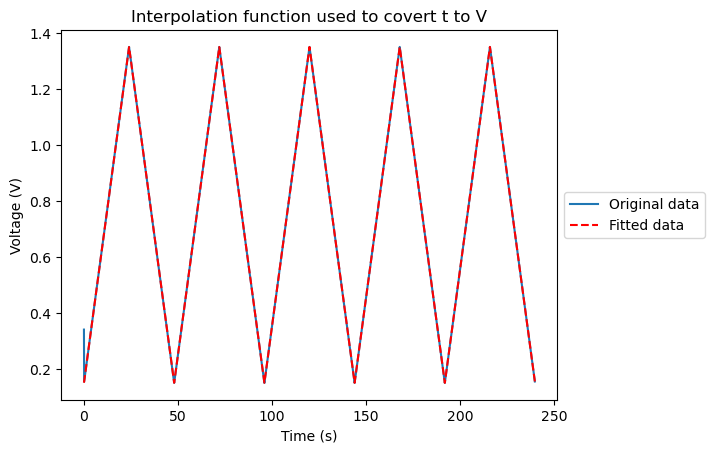

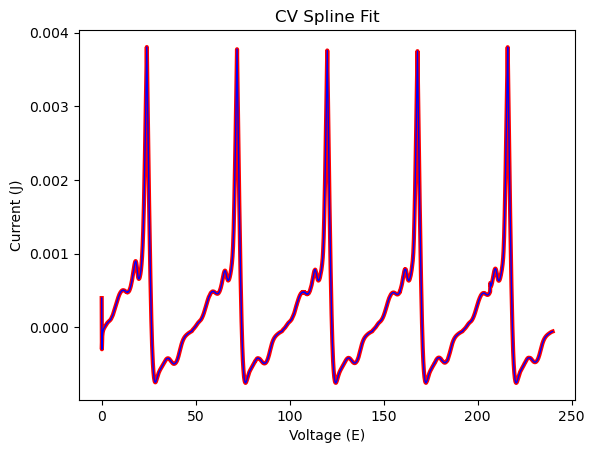

In [4]:
val=fully_read_and_calibrate_parquet(cv_path=temporary_path_fn('CV'),spec_path=temporary_path_fn("test"))

